# MNIST DBSCAN Clustering Experiments

This notebook demonstrates DBSCAN clustering on the MNIST dataset using our custom implementation.
We'll explore different parameter combinations, visualize results, and analyze cluster quality.

## Features
- Custom DBSCAN implementation with automatic strategy selection
- PCA dimensionality reduction for visualization and efficiency
- Parameter exploration (eps, min_samples)
- Cluster analysis and visualization
- Noise detection and analysis

## 1. Setup and Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from collections import Counter
import os
import warnings
warnings.filterwarnings('ignore')

# Import our custom DBSCAN implementation from the current directory
# The file dbscan.py is in the same folder as this notebook
import sys
sys.path.append('.')
from dbscan import DBSCAN

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Setup complete! 🚀")

Setup complete! 🚀


## 2. Data Loading and Preprocessing

In [5]:
def load_mnist_subset(n_samples=5000, random_state=42):
    """
    Load a subset of MNIST data for faster experimentation.
    
    Parameters
    ----------
    n_samples : int, default=5000
        Number of samples to load
    random_state : int, default=42
        Random state for reproducibility
        
    Returns
    -------
    X : ndarray of shape (n_samples, 784)
        Normalized pixel data
    y : ndarray of shape (n_samples,)
        True digit labels
    """
    print(f"Loading MNIST data (subset of {n_samples} samples)...")
    
    # Load MNIST data
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')
    X = X.astype(np.float32) / 255.0  # Normalize to [0, 1]
    y = y.astype(int)
    
    # Take a random subset
    np.random.seed(random_state)
    indices = np.random.choice(len(X), size=n_samples, replace=False)
    X_subset = X.iloc[indices] if hasattr(X, "iloc") else X[indices]
    y_subset = y.iloc[indices] if hasattr(y, "iloc") else y[indices]
    
    print(f"Loaded {len(X_subset)} samples with {X_subset.shape[1]} features")
    print(f"Class distribution: {dict(zip(*np.unique(y_subset, return_counts=True)))}")
    
    return X_subset, y_subset

# Load the data
X_raw, y_true = load_mnist_subset(n_samples=3000)  # Start with smaller subset for faster experiments

Loading MNIST data (subset of 3000 samples)...
Loaded 3000 samples with 784 features
Class distribution: {np.int64(0): np.int64(305), np.int64(1): np.int64(325), np.int64(2): np.int64(274), np.int64(3): np.int64(350), np.int64(4): np.int64(246), np.int64(5): np.int64(291), np.int64(6): np.int64(300), np.int64(7): np.int64(308), np.int64(8): np.int64(295), np.int64(9): np.int64(306)}


## 3. Dimensionality Reduction

Applying PCA: 784 → 50 dimensions
PCA completed. Explained variance: 0.637


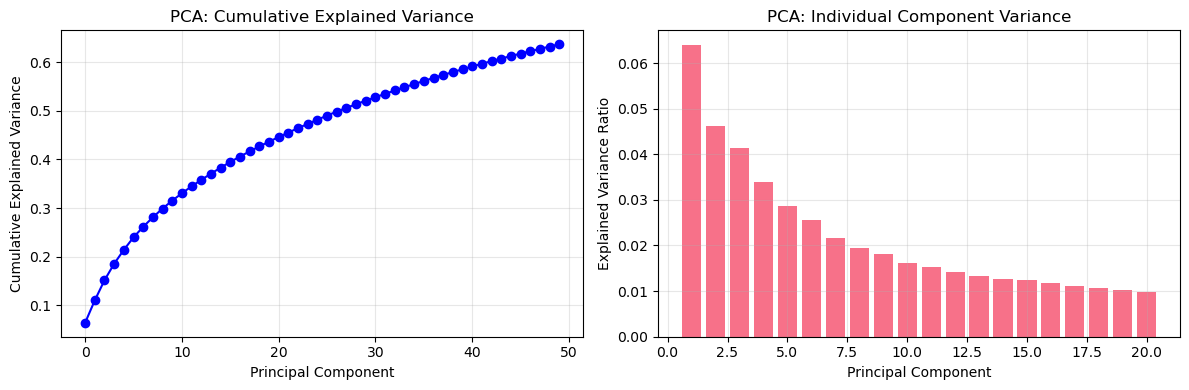

In [6]:
def apply_pca(X, n_components=50, standardize=True):
    """
    Apply PCA dimensionality reduction.
    
    Parameters
    ----------
    X : ndarray
        Input data
    n_components : int, default=50
        Number of principal components to keep
    standardize : bool, default=True
        Whether to standardize features before PCA
        
    Returns
    -------
    X_pca : ndarray
        Transformed data
    pca : PCA
        Fitted PCA object
    scaler : StandardScaler or None
        Fitted scaler if standardize=True
    """
    print(f"Applying PCA: {X.shape[1]} → {n_components} dimensions")
    
    # Standardize if requested
    scaler = None
    if standardize:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = X
    
    # Apply PCA
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    
    # Print explained variance
    explained_var = pca.explained_variance_ratio_.sum()
    print(f"PCA completed. Explained variance: {explained_var:.3f}")
    
    return X_pca, pca, scaler

# Apply PCA
X_pca, pca_model, scaler = apply_pca(X_raw, n_components=50)

# Plot explained variance
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(np.cumsum(pca_model.explained_variance_ratio_), 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(range(1, 21), pca_model.explained_variance_ratio_[:20])
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA: Individual Component Variance')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. DBSCAN Parameter Exploration

In [8]:
def analyze_dbscan_params(X, y_true, eps_values, min_samples_values, verbose=1):
    """
    Analyze DBSCAN clustering across different parameter combinations.
    """
    results = []
    
    print(f"Testing {len(eps_values)} eps values × {len(min_samples_values)} min_samples values = {len(eps_values) * len(min_samples_values)} combinations")
    
    for i, eps in enumerate(eps_values):
        for j, min_samples in enumerate(min_samples_values):
            if verbose >= 1:
                print(f"\nTesting eps={eps:.2f}, min_samples={min_samples} ({i*len(min_samples_values)+j+1}/{len(eps_values)*len(min_samples_values)})")
            
            # Run DBSCAN
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, verbose=0)
            labels = dbscan.fit_predict(X)
            
            # Calculate metrics
            n_clusters = dbscan.n_clusters_
            n_noise = np.sum(labels == -1)
            noise_ratio = n_noise / len(labels)
            
            # Calculate accuracy for non-noise points
            accuracy = calculate_cluster_accuracy(labels, y_true)
            
            # Calculate external validity metrics (excluding noise)
            non_noise_mask = labels != -1
            if np.sum(non_noise_mask) > 0 and len(np.unique(labels[non_noise_mask])) > 1:
                # Convert to numpy arrays for consistent indexing
                y_true_array = np.array(y_true) if hasattr(y_true, 'iloc') else y_true
                ari = adjusted_rand_score(y_true_array[non_noise_mask], labels[non_noise_mask])
                nmi = normalized_mutual_info_score(y_true_array[non_noise_mask], labels[non_noise_mask])
            else:
                ari = 0.0
                nmi = 0.0
            
            result = {
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'noise_ratio': noise_ratio,
                'accuracy': accuracy,
                'ari': ari,
                'nmi': nmi
            }
            
            results.append(result)
            
            if verbose >= 1:
                print(f"  → {n_clusters} clusters, {n_noise} noise points ({noise_ratio:.1%}), accuracy: {accuracy:.3f}")
    
    return pd.DataFrame(results)


def calculate_cluster_accuracy(labels, y_true):
    """Calculate clustering accuracy by assigning each cluster to its majority class."""
    if len(labels) == 0:
        return 0.0
    
    # Only consider non-noise points
    non_noise_mask = labels != -1
    if np.sum(non_noise_mask) == 0:
        return 0.0
    
    labels_clean = labels[non_noise_mask]
    # Convert to numpy array to avoid pandas Series indexing issues
    y_true_array = np.array(y_true) if hasattr(y_true, 'iloc') else y_true
    y_true_clean = y_true_array[non_noise_mask]
    
    # Find majority class for each cluster
    cluster_to_class = {}
    unique_clusters = np.unique(labels_clean)
    
    for cluster in unique_clusters:
        mask = labels_clean == cluster
        cluster_labels = y_true_clean[mask]
        majority_class = Counter(cluster_labels).most_common(1)[0][0]
        cluster_to_class[cluster] = majority_class
    
    # Calculate accuracy
    correct = 0
    for i, cluster in enumerate(labels_clean):
        if cluster_to_class[cluster] == y_true_clean[i]:
            correct += 1
    
    return correct / len(labels_clean)


# Define parameter ranges to test
eps_values = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0]
min_samples_values = [3, 5, 10, 15, 20, 30]

# Run parameter analysis
results_df = analyze_dbscan_params(X_pca, y_true, eps_values, min_samples_values)

Testing 8 eps values × 6 min_samples values = 48 combinations

Testing eps=1.00, min_samples=3 (1/48)
  → 0 clusters, 3000 noise points (100.0%), accuracy: 0.000

Testing eps=1.00, min_samples=5 (2/48)
  → 0 clusters, 3000 noise points (100.0%), accuracy: 0.000

Testing eps=1.00, min_samples=10 (3/48)
  → 0 clusters, 3000 noise points (100.0%), accuracy: 0.000

Testing eps=1.00, min_samples=15 (4/48)
  → 0 clusters, 3000 noise points (100.0%), accuracy: 0.000

Testing eps=1.00, min_samples=20 (5/48)
  → 0 clusters, 3000 noise points (100.0%), accuracy: 0.000

Testing eps=1.00, min_samples=30 (6/48)
  → 0 clusters, 3000 noise points (100.0%), accuracy: 0.000

Testing eps=1.50, min_samples=3 (7/48)
  → 0 clusters, 3000 noise points (100.0%), accuracy: 0.000

Testing eps=1.50, min_samples=5 (8/48)
  → 0 clusters, 3000 noise points (100.0%), accuracy: 0.000

Testing eps=1.50, min_samples=10 (9/48)
  → 0 clusters, 3000 noise points (100.0%), accuracy: 0.000

Testing eps=1.50, min_samples=15

## 5. Results Visualization

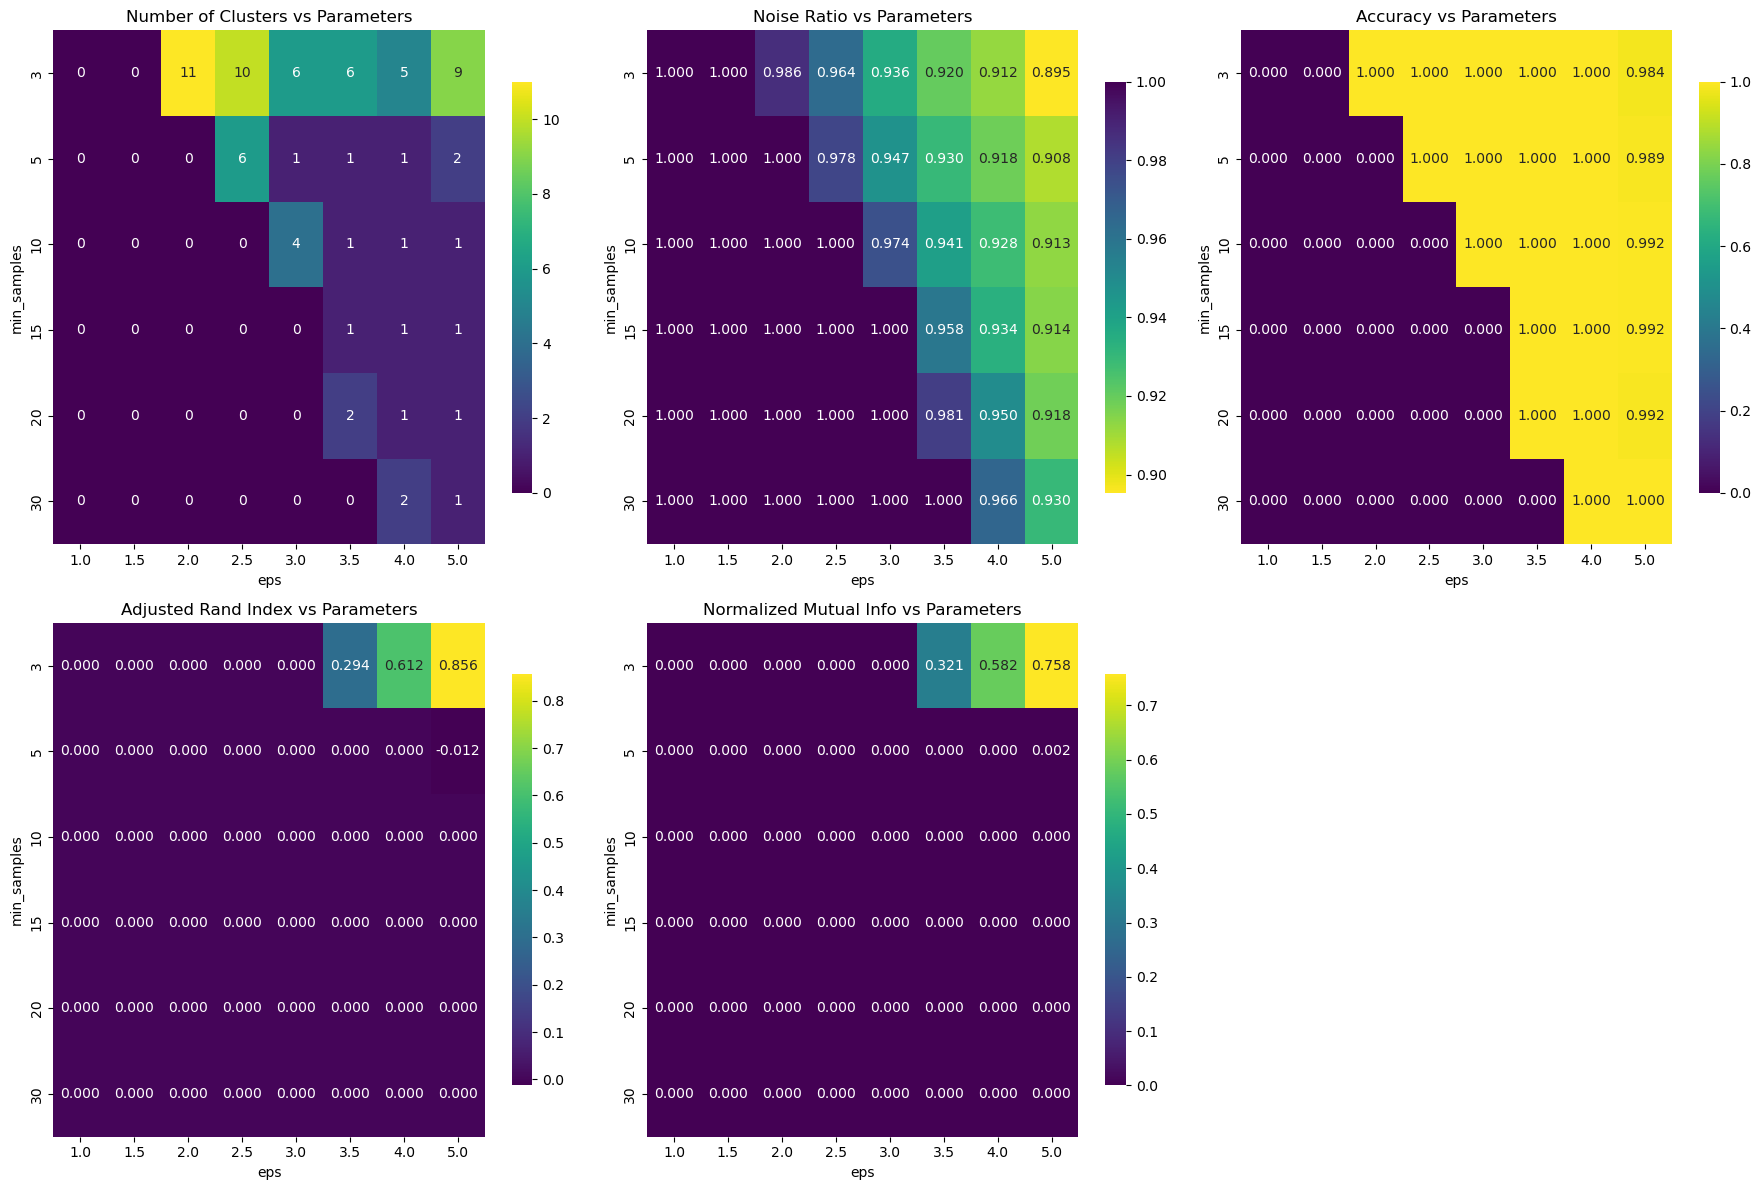


=== Best Parameter Combinations ===
Best Accuracy: 1.000
  Parameters: eps=2.0, min_samples=3.0
  Clusters: 11.0, Noise: 98.6%

Best ARI: 0.856
  Parameters: eps=5.0, min_samples=3.0
  Clusters: 9.0, Noise: 89.5%

Best Balance (Accuracy + ARI + Low Noise): 0.682
  Parameters: eps=5.0, min_samples=3.0
  Clusters: 9.0, Noise: 89.5%


In [9]:
def plot_parameter_analysis(results_df):
    """Create comprehensive plots showing how DBSCAN metrics vary with parameters."""
    # Create pivot tables for heatmaps
    metrics = ['n_clusters', 'noise_ratio', 'accuracy', 'ari', 'nmi']
    metric_names = ['Number of Clusters', 'Noise Ratio', 'Accuracy', 'Adjusted Rand Index', 'Normalized Mutual Info']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, (metric, name) in enumerate(zip(metrics, metric_names)):
        if i >= len(axes):
            break
            
        # Create pivot table
        pivot_data = results_df.pivot(index='min_samples', columns='eps', values=metric)
        
        # Create heatmap
        sns.heatmap(pivot_data, 
                   annot=True, 
                   fmt='.3f' if metric in ['noise_ratio', 'accuracy', 'ari', 'nmi'] else '.0f',
                   cmap='viridis' if metric != 'noise_ratio' else 'viridis_r',
                   ax=axes[i],
                   cbar_kws={'shrink': 0.8})
        
        axes[i].set_title(f'{name} vs Parameters')
        axes[i].set_xlabel('eps')
        axes[i].set_ylabel('min_samples')
    
    # Remove empty subplot
    if len(metrics) < len(axes):
        fig.delaxes(axes[-1])
    
    plt.tight_layout()
    plt.show()
    
    # Find best parameters
    print("\n=== Best Parameter Combinations ===")
    
    # Best accuracy
    best_acc_idx = results_df['accuracy'].idxmax()
    best_acc = results_df.loc[best_acc_idx]
    print(f"Best Accuracy: {best_acc['accuracy']:.3f}")
    print(f"  Parameters: eps={best_acc['eps']}, min_samples={best_acc['min_samples']}")
    print(f"  Clusters: {best_acc['n_clusters']}, Noise: {best_acc['noise_ratio']:.1%}")
    
    # Best ARI
    best_ari_idx = results_df['ari'].idxmax()
    best_ari = results_df.loc[best_ari_idx]
    print(f"\nBest ARI: {best_ari['ari']:.3f}")
    print(f"  Parameters: eps={best_ari['eps']}, min_samples={best_ari['min_samples']}")
    print(f"  Clusters: {best_ari['n_clusters']}, Noise: {best_ari['noise_ratio']:.1%}")
    
    # Balance of clusters and low noise
    results_df['balance_score'] = (results_df['accuracy'] * 0.4 + 
                                  results_df['ari'] * 0.3 + 
                                  (1 - results_df['noise_ratio']) * 0.3)
    best_balance_idx = results_df['balance_score'].idxmax()
    best_balance = results_df.loc[best_balance_idx]
    print(f"\nBest Balance (Accuracy + ARI + Low Noise): {best_balance['balance_score']:.3f}")
    print(f"  Parameters: eps={best_balance['eps']}, min_samples={best_balance['min_samples']}")
    print(f"  Clusters: {best_balance['n_clusters']}, Noise: {best_balance['noise_ratio']:.1%}")
    
    return best_acc, best_ari, best_balance

# Plot the analysis
best_configs = plot_parameter_analysis(results_df)

## 6. Detailed Analysis of Best Configuration

In [10]:
def analyze_best_clustering(X, y_true, eps, min_samples):
    """Perform detailed analysis of clustering results with specific parameters."""
    print(f"\n=== Detailed Analysis: eps={eps}, min_samples={min_samples} ===")
    
    # Run DBSCAN with verbose output
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, verbose=1)
    labels = dbscan.fit_predict(X)
    
    # Basic statistics
    n_clusters = dbscan.n_clusters_
    n_noise = np.sum(labels == -1)
    n_total = len(labels)
    
    print(f"\nClustering Results:")
    print(f"  Total samples: {n_total}")
    print(f"  Number of clusters: {n_clusters}")
    print(f"  Noise points: {n_noise} ({n_noise/n_total:.1%})")
    print(f"  Clustered points: {n_total - n_noise} ({(n_total-n_noise)/n_total:.1%})")
    
    # Cluster size distribution
    if n_clusters > 0:
        cluster_sizes = Counter(labels[labels != -1])
        print(f"\nCluster Sizes:")
        for cluster in sorted(cluster_sizes.keys()):
            print(f"  Cluster {cluster}: {cluster_sizes[cluster]} points")
    
    # Cluster composition (digit distribution)
    print(f"\nCluster Composition:")
    composition_matrix = np.zeros((n_clusters, 10))  # 10 digits
    
    for cluster in range(n_clusters):
        mask = labels == cluster
        if np.sum(mask) > 0:
            digit_counts = Counter(y_true[mask])
            total_in_cluster = np.sum(mask)
            print(f"\n  Cluster {cluster} ({total_in_cluster} points):")
            
            for digit in range(10):
                count = digit_counts.get(digit, 0)
                percentage = count / total_in_cluster * 100
                composition_matrix[cluster, digit] = percentage
                if count > 0:
                    print(f"    Digit {digit}: {count} ({percentage:.1f}%)")
    
    return labels, composition_matrix


# Use the best balanced configuration
best_config = best_configs[2]  # best_balance
best_eps = best_config['eps']
best_min_samples = best_config['min_samples']

labels_best, composition_matrix = analyze_best_clustering(X_pca, y_true, best_eps, int(best_min_samples))


=== Detailed Analysis: eps=5.0, min_samples=3 ===
Clustering 3000 samples with DBSCAN
Parameters: eps=5.0, min_samples=3
Using optimized approach (medium dataset)
Found 9 clusters and 2686 noise points

Clustering Results:
  Total samples: 3000
  Number of clusters: 9
  Noise points: 2686 (89.5%)
  Clustered points: 314 (10.5%)

Cluster Sizes:
  Cluster 0: 285 points
  Cluster 1: 4 points
  Cluster 2: 4 points
  Cluster 3: 5 points
  Cluster 4: 3 points
  Cluster 5: 3 points
  Cluster 6: 3 points
  Cluster 7: 4 points
  Cluster 8: 3 points

Cluster Composition:

  Cluster 0 (285 points):
    Digit 1: 281 (98.6%)
    Digit 3: 3 (1.1%)
    Digit 7: 1 (0.4%)

  Cluster 1 (4 points):
    Digit 9: 4 (100.0%)

  Cluster 2 (4 points):
    Digit 7: 4 (100.0%)

  Cluster 3 (5 points):
    Digit 7: 5 (100.0%)

  Cluster 4 (3 points):
    Digit 9: 3 (100.0%)

  Cluster 5 (3 points):
    Digit 7: 1 (33.3%)
    Digit 9: 2 (66.7%)

  Cluster 6 (3 points):
    Digit 1: 3 (100.0%)

  Cluster 7 (4 poi

## 7. Cluster Visualization

Creating 2D visualization using TSNE...


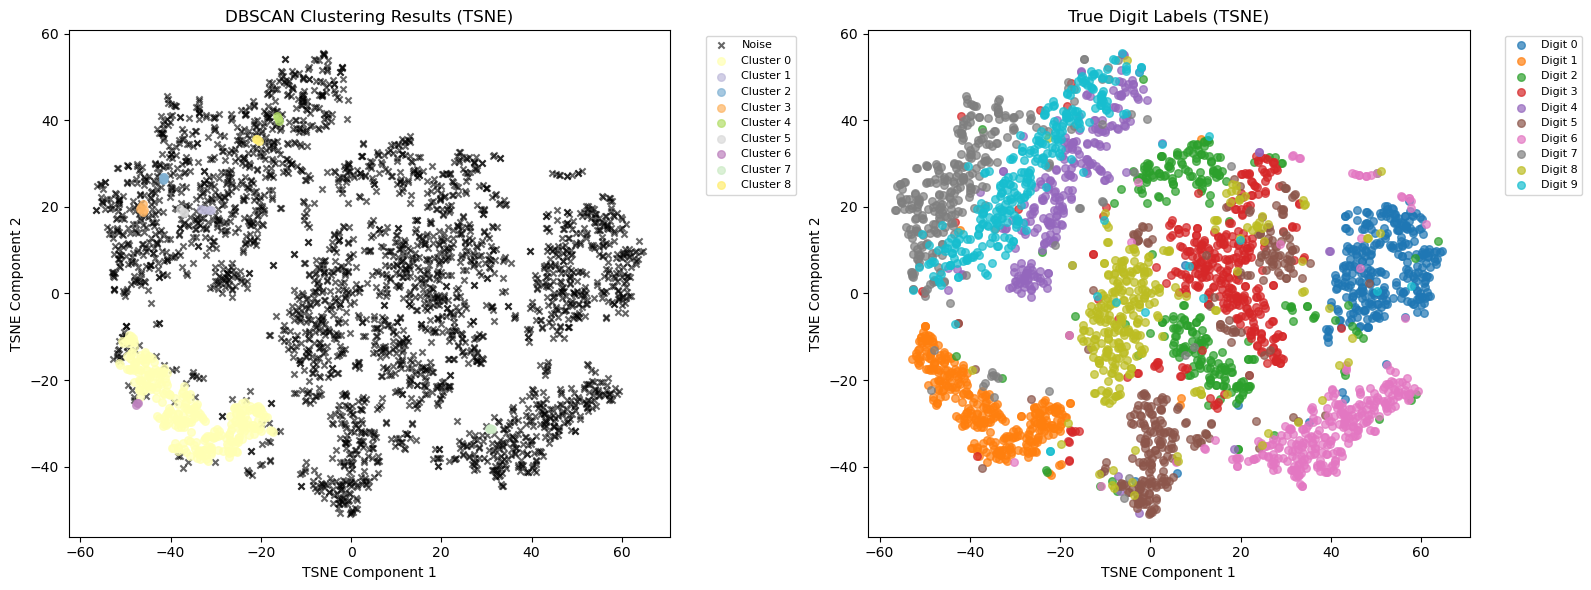

In [11]:
def visualize_clusters(X, labels, y_true, method='tsne', perplexity=30):
    """Visualize clustering results in 2D using t-SNE or PCA."""
    print(f"Creating 2D visualization using {method.upper()}...")
    
    if method.lower() == 'tsne':
        # Use t-SNE for 2D visualization
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
        X_2d = tsne.fit_transform(X)
    else:
        # Use PCA for 2D visualization
        pca_2d = PCA(n_components=2, random_state=42)
        X_2d = pca_2d.fit_transform(X)
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot by cluster labels
    unique_labels = np.unique(labels)
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_labels)))
    
    for label, color in zip(unique_labels, colors):
        if label == -1:
            # Noise points in black
            mask = labels == label
            ax1.scatter(X_2d[mask, 0], X_2d[mask, 1], 
                       c='black', marker='x', s=20, alpha=0.6, label='Noise')
        else:
            mask = labels == label
            ax1.scatter(X_2d[mask, 0], X_2d[mask, 1], 
                       c=[color], s=30, alpha=0.7, label=f'Cluster {label}')
    
    ax1.set_title(f'DBSCAN Clustering Results ({method.upper()})')
    ax1.set_xlabel(f'{method.upper()} Component 1')
    ax1.set_ylabel(f'{method.upper()} Component 2')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    # Plot by true digit labels
    digit_colors = plt.cm.tab10(np.linspace(0, 1, 10))
    for digit in range(10):
        mask = y_true == digit
        ax2.scatter(X_2d[mask, 0], X_2d[mask, 1], 
                   c=[digit_colors[digit]], s=30, alpha=0.7, label=f'Digit {digit}')
    
    ax2.set_title(f'True Digit Labels ({method.upper()})')
    ax2.set_xlabel(f'{method.upper()} Component 1')
    ax2.set_ylabel(f'{method.upper()} Component 2')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    return X_2d


# Visualize the best clustering results
X_2d = visualize_clusters(X_pca, labels_best, y_true, method='tsne')

## 8. Save Results

In [12]:
# Create results directory (relative to current dbscan folder)
results_dir = 'results_dbscan'
os.makedirs(results_dir, exist_ok=True)

# Save parameter exploration results
results_df.to_csv(f'{results_dir}/parameter_exploration.csv', index=False)
print(f"Parameter exploration results saved to {results_dir}/parameter_exploration.csv")

# Save best configuration
best_config_df = pd.DataFrame([best_configs[2]])
best_config_df.to_csv(f'{results_dir}/best_configuration.csv', index=False)
print(f"Best configuration saved to {results_dir}/best_configuration.csv")

print(f"\nAll results saved to {results_dir}/ directory")
print("\n🎉 DBSCAN experiments completed successfully!")

Parameter exploration results saved to results_dbscan/parameter_exploration.csv
Best configuration saved to results_dbscan/best_configuration.csv

All results saved to results_dbscan/ directory

🎉 DBSCAN experiments completed successfully!
